In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import os

In [2]:
# DATA

# import

file_path = os.path.join('test_weather_data.csv')
data = pd.read_csv(file_path)

data.head()


,index,time,airT,rainIntensity,rH,solarRadiance,windDir,windSpeed,pressure
0,1133,2020-11-05 12:15:00+00:00,10.9,0.0,76.4,111.4,233.0,1.13,99010.0
1,1134,2020-11-05 12:20:00+00:00,10.9,0.0,76.7,115.5,245.0,1.17,99010.0
2,1135,2020-11-05 12:25:00+00:00,11.0,0.0,75.5,117.2,243.0,1.64,99010.0
3,1136,2020-11-05 12:30:00+00:00,11.0,0.0,76.0,118.8,226.0,1.54,99000.0
4,1137,2020-11-05 12:35:00+00:00,11.0,0.0,74.2,120.4,221.0,1.90,99000.0


In [3]:
# rename columns to match the old format
new_data = data.rename(columns={
    'time': 'acquisition_timestamp',
    'airT': 'AMBIENT_TEMPERATURE',
    'rainIntensity': 'RAIN_INTENSITY',
    'rH': 'RELATIVE_HUMIDITY',
    'solarRadiance': 'SOLAR_RADIATION_INTENSITY',
    'windDir': 'WIND_DIRECTION',
    'windSpeed': 'WIND_SPEED',
    'pressure': 'AIR_PRESSURE'
})

# convert acquisition_timestamp to datetime
new_data['acquisition_timestamp'] = pd.to_datetime(new_data['acquisition_timestamp'], utc=True)

new_data = new_data.drop(columns=['index'])

# set the 'acquisition_timestamp' as the index
new_data = new_data.set_index('acquisition_timestamp')

# rearrange columns to match the old format
new_data = new_data[[
    'AIR_PRESSURE', 'AMBIENT_TEMPERATURE', 'RAIN_INTENSITY', 
    'RELATIVE_HUMIDITY', 'SOLAR_RADIATION_INTENSITY', 
    'WIND_DIRECTION', 'WIND_SPEED'
]]

new_data.head()


,AIR_PRESSURE,AMBIENT_TEMPERATURE,RAIN_INTENSITY,RELATIVE_HUMIDITY,SOLAR_RADIATION_INTENSITY,WIND_DIRECTION,WIND_SPEED
acquisition_timestamp,,,,,,,
2020-11-05 12:15:00+00:00,99010.0,10.9,0.0,76.4,111.4,233.0,1.13
2020-11-05 12:20:00+00:00,99010.0,10.9,0.0,76.7,115.5,245.0,1.17
2020-11-05 12:25:00+00:00,99010.0,11.0,0.0,75.5,117.2,243.0,1.64
2020-11-05 12:30:00+00:00,99000.0,11.0,0.0,76.0,118.8,226.0,1.54
2020-11-05 12:35:00+00:00,99000.0,11.0,0.0,74.2,120.4,221.0,1.90


In [4]:
# relative humidity
humidity = new_data[['RELATIVE_HUMIDITY']]
print(humidity)

# count the NaN values
nan_count_humidity = humidity['RELATIVE_HUMIDITY'].isna().sum()
print(f'Nan Count Temperature :',nan_count_humidity)
# there are no NaN values

# check for missing measurements (skipped times)
complete_range = pd.date_range(start=humidity.index.min(), end=humidity.index.max(), freq='5T')
missing_timestamps = complete_range.difference(humidity.index)
print(f'Length of missing timestamps :',len(missing_timestamps))
#print(complete_range)
df_complete_range = pd.DataFrame(index=complete_range)
print(f'Data Complete Range :',len(df_complete_range))
# we have 271508 measurements, there are 5112 missing measurment out of 276620 time steps in the whole time range

# merge all the air pressure measurements with all the time steps. missing measurment will be NaN values for now
humidity_incomplete = df_complete_range.merge(humidity, left_index=True, right_index=True, how='left')
# print(humidity_incomplete)
humidity_incomplete.isna().sum() # okay

# missing measurements are filled with the next available measurement
humidity_all = humidity_incomplete.bfill()
print(f'Temperature all :',humidity_all)
print(f'Sum of na Tempertaure all :',humidity_all.isna().sum()) # okay

str(humidity_all.index.dtype) # okay

                           RELATIVE_HUMIDITY
acquisition_timestamp                       
2020-11-05 12:15:00+00:00               76.4
2020-11-05 12:20:00+00:00               76.7
2020-11-05 12:25:00+00:00               75.5
2020-11-05 12:30:00+00:00               76.0
2020-11-05 12:35:00+00:00               74.2
...                                      ...
2023-05-31 21:35:00+00:00               85.6
2023-05-31 21:40:00+00:00               84.9
2023-05-31 21:45:00+00:00               85.3
2023-05-31 21:50:00+00:00               85.9
2023-05-31 21:55:00+00:00               85.2

[265803 rows x 1 columns]
Nan Count Temperature : 6
Length of missing timestamps : 4170
Data Complete Range : 269973
Temperature all :                            RELATIVE_HUMIDITY
2020-11-05 12:15:00+00:00               76.4
2020-11-05 12:20:00+00:00               76.7
2020-11-05 12:25:00+00:00               75.5
2020-11-05 12:30:00+00:00               76.0
2020-11-05 12:35:00+00:00               74.2
...      

'datetime64[ns, UTC]'

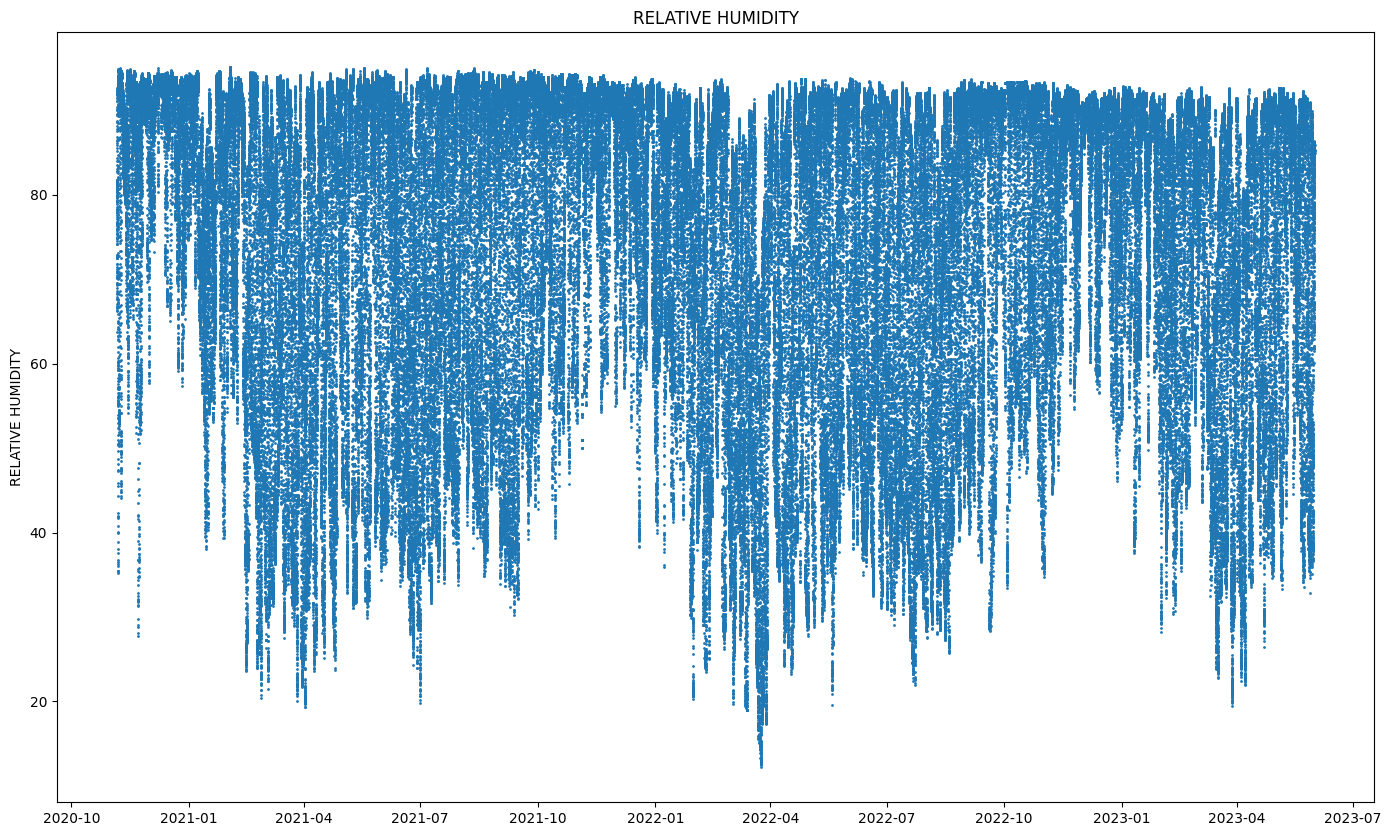

In [5]:
# plot 'RELATIVE_HUMIDITY'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(humidity_all.index, humidity_all['RELATIVE_HUMIDITY'],s=1)
ax.set_ylabel('RELATIVE HUMIDITY')  
ax.set_title('RELATIVE HUMIDITY')  
plt.show()

                           RELATIVE_HUMIDITY
2020-11-05 12:00:00+00:00          75.266667
2020-11-05 13:00:00+00:00          71.108333
2020-11-05 14:00:00+00:00          68.725000
2020-11-05 15:00:00+00:00          72.100000
2020-11-05 16:00:00+00:00          79.641667
...                                      ...
2023-05-31 17:00:00+00:00          81.625000
2023-05-31 18:00:00+00:00          83.583333
2023-05-31 19:00:00+00:00          84.825000
2023-05-31 20:00:00+00:00          85.691667
2023-05-31 21:00:00+00:00          85.683333

[22498 rows x 1 columns]


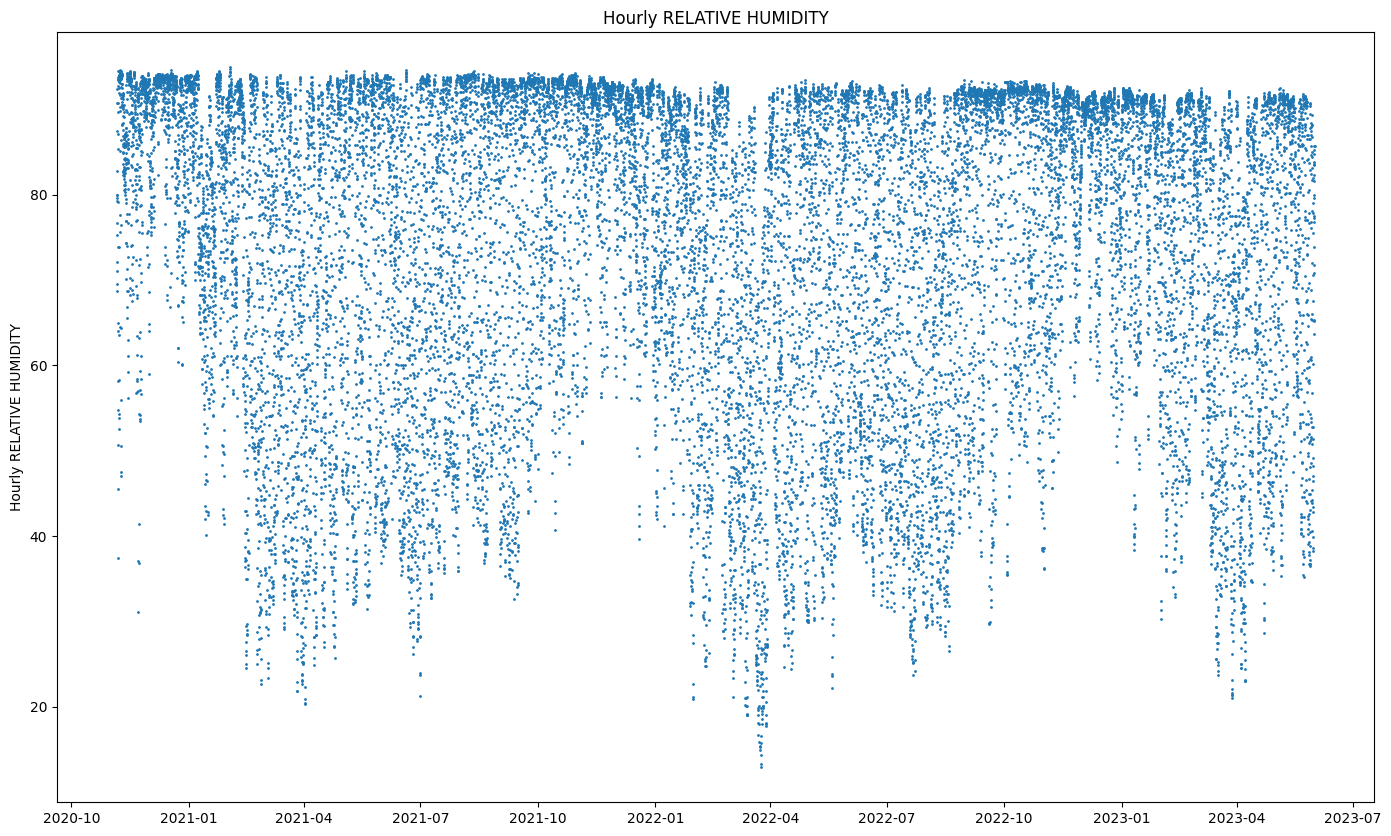

In [6]:
# hourly data
# sum the values for each hour and take the mean

str(humidity_all.index.dtype) # okay
humidity_hourly = humidity_all.resample('H').mean()
print(humidity_hourly)

# plot hourly 'AMBIENT_TEMPERATURE'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(humidity_hourly.index, humidity_hourly['RELATIVE_HUMIDITY'],s=1)
ax.set_ylabel('Hourly RELATIVE HUMIDITY')  
ax.set_title('Hourly RELATIVE HUMIDITY')  
plt.show()

In [7]:
# fit the old models to the new data 


from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Define both fits
order_1=(2,1,1)
order_2=(3,0,4)


                               SARIMAX Results                                
Dep. Variable:      RELATIVE_HUMIDITY   No. Observations:                22498
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -65428.485
Date:                Wed, 22 May 2024   AIC                         130864.969
Time:                        03:07:09   BIC                         130897.054
Sample:                    11-05-2020   HQIC                        130875.407
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1119      0.050      2.244      0.025       0.014       0.210
ar.L2          0.2108      0.032      6.587      0.000       0.148       0.273
ma.L1          0.5151      0.050     10.404      0.0

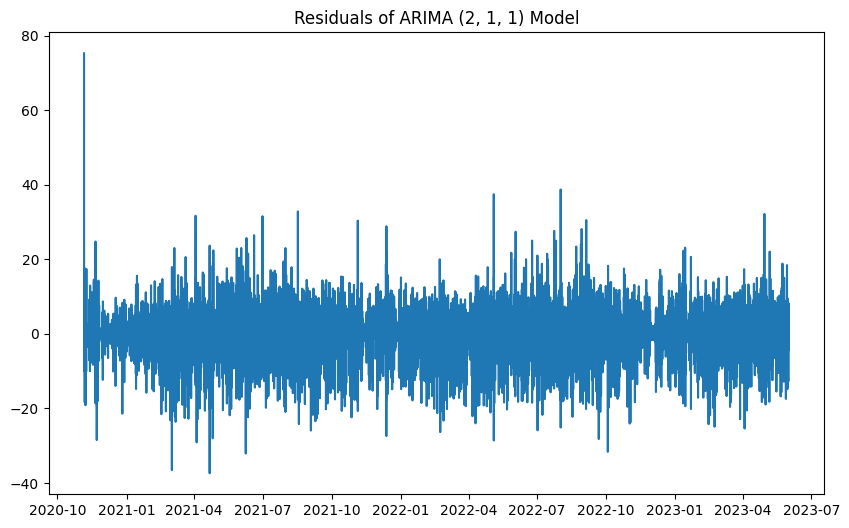

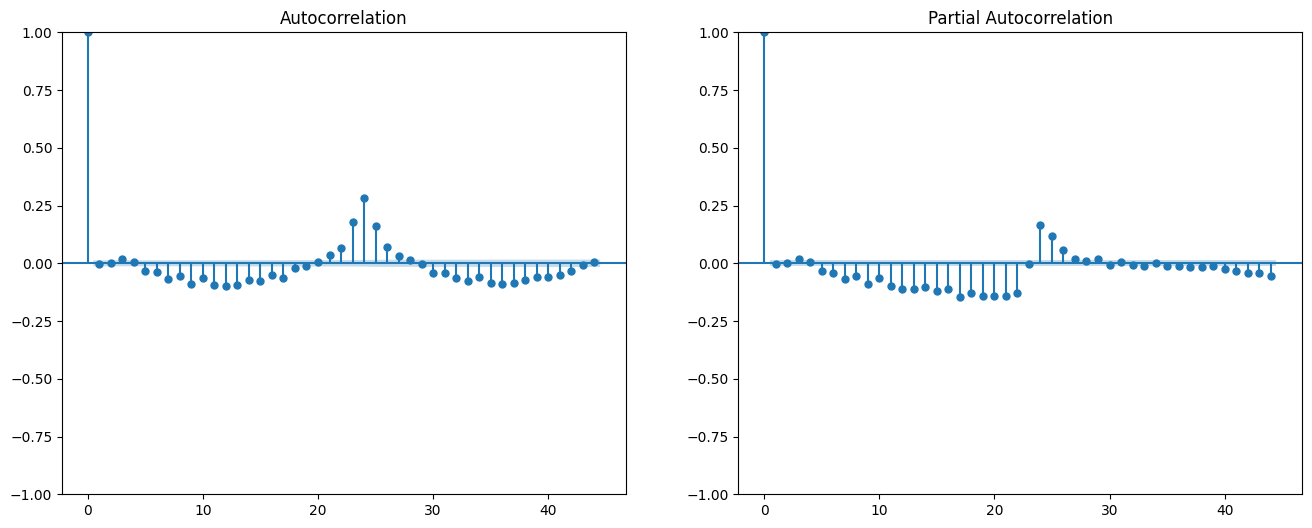

In [8]:

# fit the model number 1
best_model_1 = ARIMA(humidity_hourly, order=order_1)   # change order accordingly
best_fit_1 = best_model_1.fit()

# summary of the best model
print(best_fit_1.summary())

# residuals of the best model
residuals_best_1 = best_fit_1.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best_1)
plt.title(f'Residuals of ARIMA {order_1} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best_1, ax=ax[0], alpha=0.05)
plot_pacf(residuals_best_1, ax=ax[1], alpha=0.05)
plt.show()

                               SARIMAX Results                                
Dep. Variable:      RELATIVE_HUMIDITY   No. Observations:                22498
Model:                 ARIMA(3, 0, 4)   Log Likelihood              -63276.600
Date:                Wed, 22 May 2024   AIC                         126571.199
Time:                        03:07:40   BIC                         126643.390
Sample:                    11-05-2020   HQIC                        126594.684
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.0868      0.563    131.501      0.000      72.983      75.191
ar.L1          2.8473      0.004    746.999      0.000       2.840       2.855
ar.L2         -2.7684      0.007   -377.233      0.0

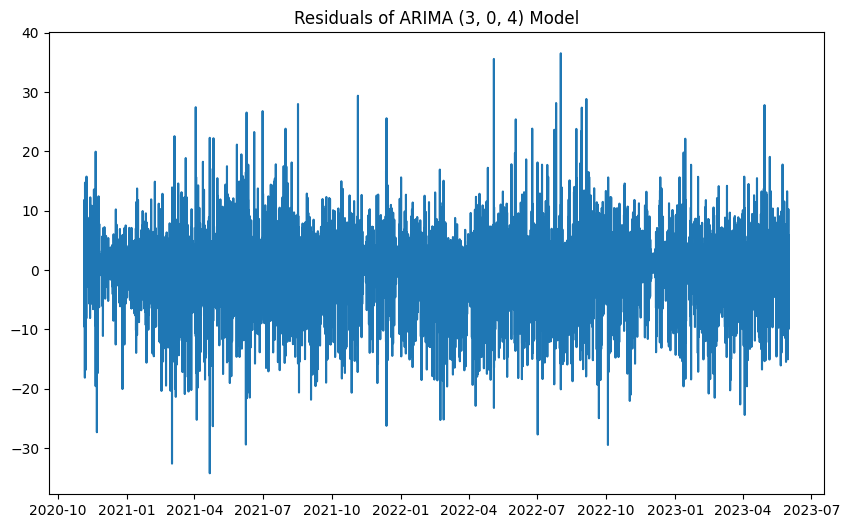

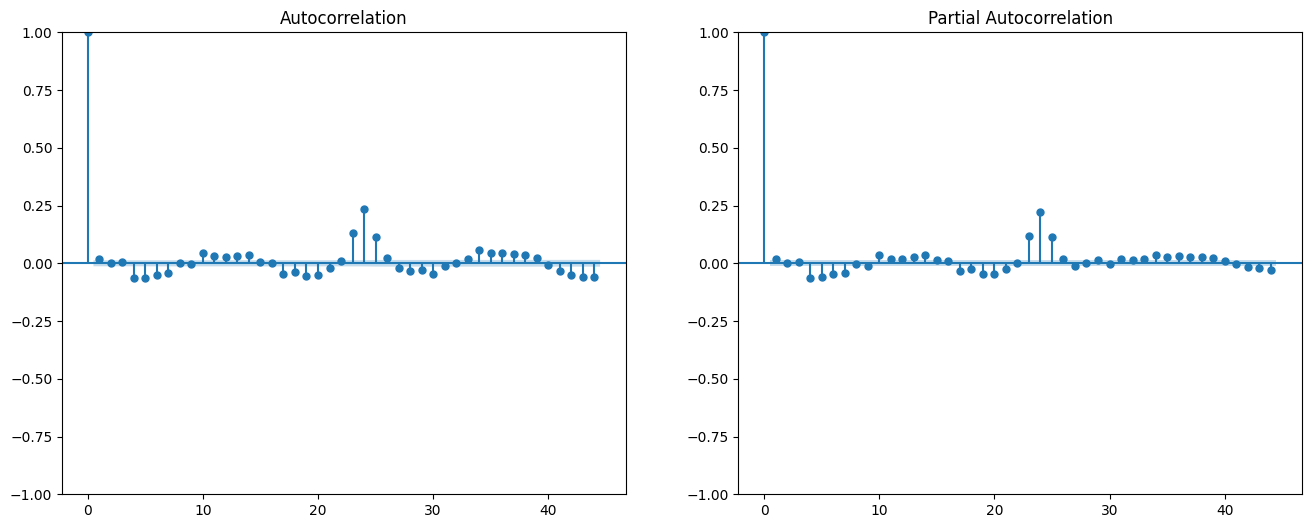

In [9]:
# fit the model number 2
best_model_2 = ARIMA(humidity_hourly, order=order_2)   # change order accordingly
best_fit_2 = best_model_2.fit()

# summary of the best model
print(best_fit_2.summary())

# residuals of the best model
residuals_best_2 = best_fit_2.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best_2)
plt.title(f'Residuals of ARIMA {order_2} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best_2, ax=ax[0], alpha=0.05)
plot_pacf(residuals_best_2, ax=ax[1], alpha=0.05)
plt.show()

In [10]:
# data for 2020, 2021, 2022
# fit the best model to this data
# 2 best ARIMAs: (2,1,1) and (3,0,4) - try both
# forecast the next 24 hours 
# compare forecast from ARIMA and simple model with actual values (maybe 2 simple models)
# plot forecasts, plot errors

humidity_20_21_22 = humidity_hourly.loc[(humidity_hourly.index.year == 2020) | (humidity_hourly.index.year == 2021) | (humidity_hourly.index.year == 2022) , 'RELATIVE_HUMIDITY']
print(humidity_20_21_22)

2020-11-05 12:00:00+00:00    75.266667
2020-11-05 13:00:00+00:00    71.108333
2020-11-05 14:00:00+00:00    68.725000
2020-11-05 15:00:00+00:00    72.100000
2020-11-05 16:00:00+00:00    79.641667
                               ...    
2022-12-31 19:00:00+00:00    76.225000
2022-12-31 20:00:00+00:00    81.658333
2022-12-31 21:00:00+00:00    84.666667
2022-12-31 22:00:00+00:00    87.750000
2022-12-31 23:00:00+00:00    88.183333
Freq: H, Name: RELATIVE_HUMIDITY, Length: 18876, dtype: float64


In [11]:
# 1st simple model
# average of the previous 3 days is the value for the next day

def last_3_days_average(data, forecasted_steps):
    # Forecasts the next values based on the average of the last 3 days at the same time.
    forecast = []

    for step in range(forecasted_steps):

        next_time_step = data.index[-1] + pd.Timedelta(hours=1) # finds out the next time step
        
        last_3_days = [
            next_time_step - pd.Timedelta(days=i) for i in range(1, 4)     # gets the same hour from the last 3 days
        ]
        
        values = [data[data.index == dt].values for dt in last_3_days] # extracts the values at the same hour from the last 3 days
        values = [val[0] if len(val) > 0 else np.nan for val in values]
        
        forecast_value = np.nanmean(values) # mean of the last 3 days
        
        forecast.append(forecast_value)
        
        data = pd.concat([data, pd.Series([forecast_value], index=[next_time_step])]) # adds the forecasted value to the data for the next iteration

    return pd.Series(forecast, index=[data.index[-forecasted_steps + i] for i in range(forecasted_steps)])

last_3_days_average(humidity_20_21_22, 24)

last_3_humidity = last_3_days_average(humidity_20_21_22, 24)


In [13]:
# 2nd simple model
# today's measurement is tomorrow's forecast

def today_is_tomorrow(data, forecasted_steps):

    forecast = []

    for step in range(forecasted_steps):

        next_time_step = data.index[-1] + pd.Timedelta(hours=1)
        
        same_hour_last_day = next_time_step - pd.Timedelta(days=1)
        
        forecast_value = data.loc[same_hour_last_day]
        
        forecast.append(forecast_value)
        
        data = pd.concat([data, pd.Series([forecast_value], index=[next_time_step])])

    return pd.Series(forecast, index=[data.index[-forecasted_steps + i] for i in range(forecasted_steps)])

today_is_tomorrow(humidity_20_21_22, 24)

today_is_tomorrow_humidity = today_is_tomorrow(humidity_20_21_22, 24)


ARIMA(3,0,4) is preferred based on AIC.

In [14]:
# ARIMA(3,0,4) (2nd fit)

# change p,d,q to the best found

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


# fit
model_304 = ARIMA(humidity_20_21_22, order=(3,0,4))
fit_304 = model_304.fit()

# summary of the fit
print(fit_304.summary())

# ARIMA forecast for 1 day (24 steps) into the future

forecast_result_304 = fit_304.get_forecast(steps=24)
forecast_values_304 = forecast_result_304.predicted_mean
conf_int_304 = forecast_result_304.conf_int()

print("Forecasted values:", forecast_values_304)
print("95% Confidence intervals of forecasts:", conf_int_304)

                               SARIMAX Results                                
Dep. Variable:      RELATIVE_HUMIDITY   No. Observations:                18876
Model:                 ARIMA(3, 0, 4)   Log Likelihood              -53144.929
Date:                Wed, 22 May 2024   AIC                         106307.857
Time:                        03:09:13   BIC                         106378.468
Sample:                    11-05-2020   HQIC                        106331.024
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.3643      0.688    108.157      0.000      73.017      75.712
ar.L1          2.8552      0.004    686.897      0.000       2.847       2.863
ar.L2         -2.7835      0.008   -347.530      0.0

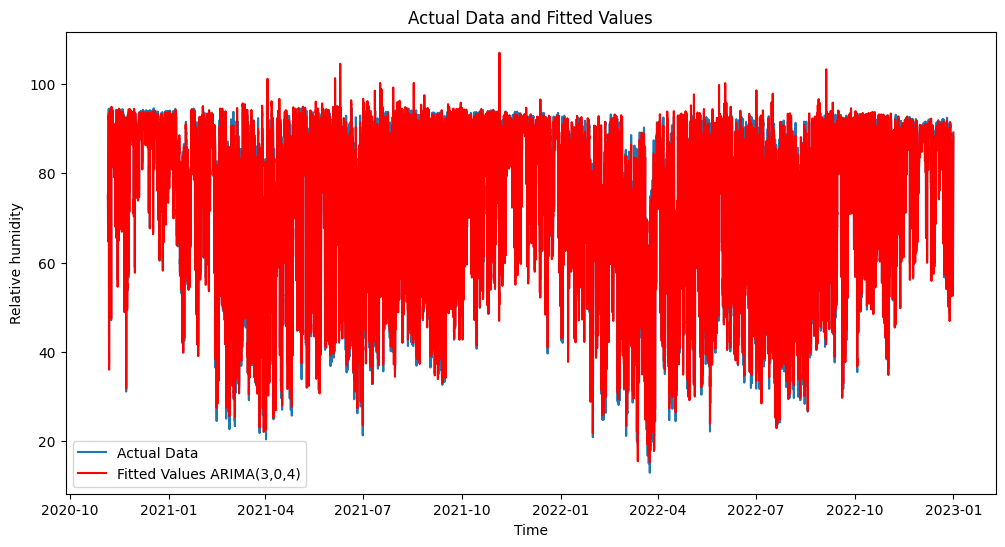

In [15]:
# plot actual data and fitted values - 2ND ARIMA
# change p,d,q to the best found

# fitted values
fitted_values_304 = fit_304.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(humidity_20_21_22.index, humidity_20_21_22, label='Actual Data')
plt.plot(humidity_20_21_22.index, fitted_values_304, color='red', label='Fitted Values ARIMA(3,0,4)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Relative humidity')
plt.title('Actual Data and Fitted Values')
plt.show()

# this looks too good

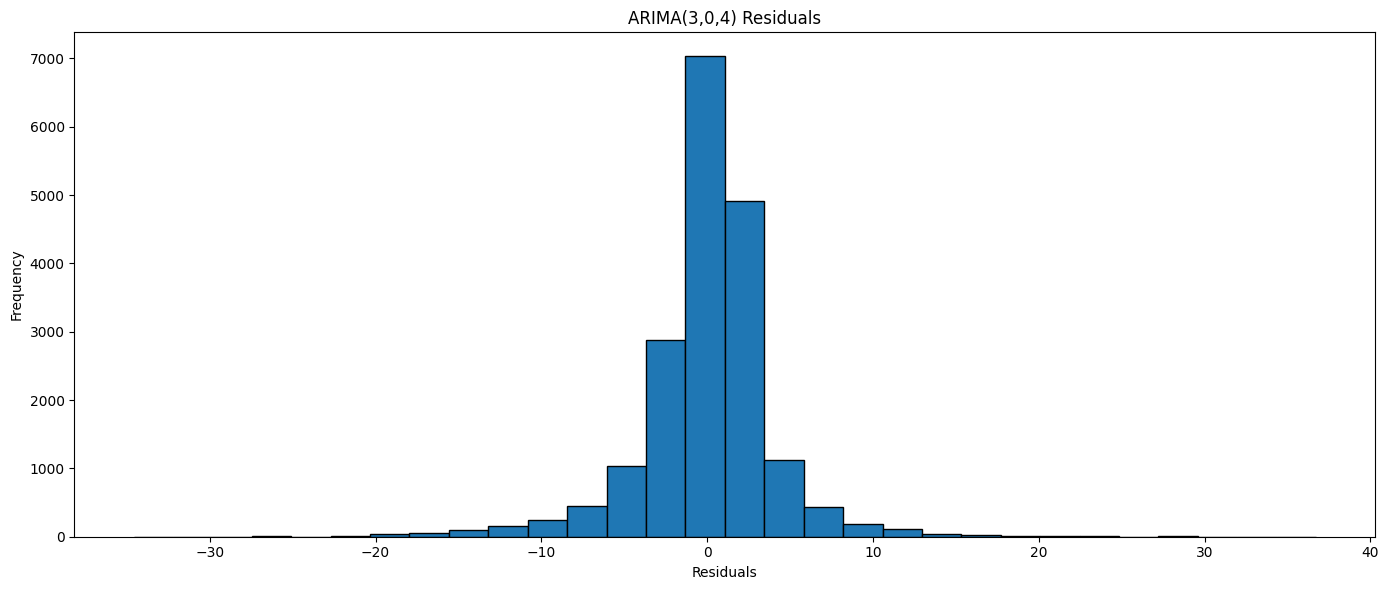

In [16]:
# comparison of the histograms

# residuals

residuals_304 = fit_304.resid

plt.figure(figsize=(14, 6))
plt.hist(residuals_304, bins=30, edgecolor='k')
plt.title('ARIMA(3,0,4) Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')



plt.tight_layout()
plt.show()


In [17]:
# statistical test and metricts to determine which model is better

import math 
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

# mean of the residuals (should be 0)

mean2 = np.mean(residuals_304)
#print(mean1, mean2)

# AIC (already done above) - writte about AIC in the report

aic2 = fit_304.aic
#print(aic1, aic2)


# Ljung-Box test for autocorrelation - see model fit output

# BIC - see model fit output

Mean Absolute Error: 2.6074510963205695
Mean Squared Error: 16.32914528956558


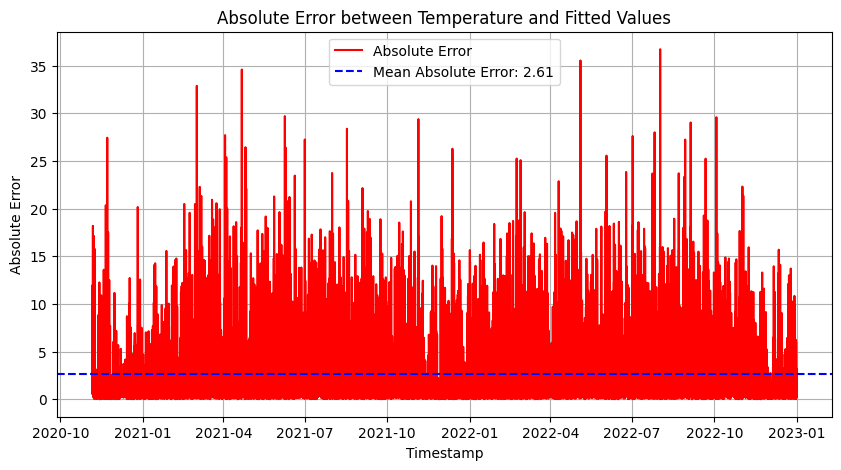

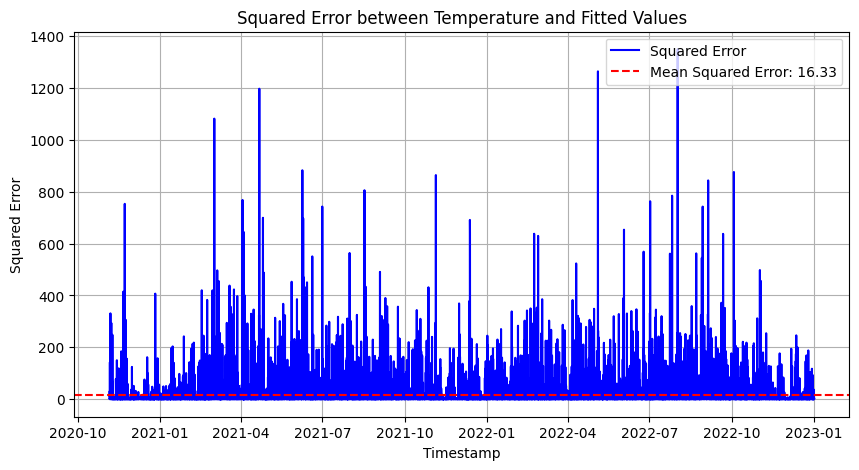

In [18]:
# absolute error comparison - actual data vs fitted model data

def calculate_errors(data, model): 
      # model are fitted values of a chosen model
  if isinstance(data, pd.Series) and isinstance(model, pd.Series):
        absolute_error = (data - model).abs()
        squared_error = (data - model) ** 2
  elif isinstance(data, np.ndarray) and isinstance(model, np.ndarray):
        absolute_error = np.abs(data - model)
        squared_error = (data - model) ** 2
  errors = pd.DataFrame({
        'absolute_error': absolute_error,
        'squared_error': squared_error
  })

  return errors

# (3,0,4) is the preferred, lets compare this data with actual data
# actual data - temperature_20_21_22
# fitted values data - fitted_values_412 

errors = calculate_errors(humidity_20_21_22, fitted_values_304 )

# mean errors
mean_absolute_error = errors['absolute_error'].mean()
mean_squared_error = errors['squared_error'].mean()
print("Mean Absolute Error:", mean_absolute_error)
print("Mean Squared Error:", mean_squared_error)

# plot of the absolute error
plt.figure(figsize=(10, 5))
plt.plot(errors['absolute_error'], label='Absolute Error', color='red')
plt.axhline(y=mean_absolute_error, color='blue', linestyle='--', label=f'Mean Absolute Error: {mean_absolute_error:.2f}')
plt.xlabel('Timestamp')
plt.ylabel('Absolute Error')
plt.title('Absolute Error between Temperature and Fitted Values')
plt.legend()
plt.grid(True)
plt.show()

# plot of the squared error
plt.figure(figsize=(10, 5))
plt.plot(errors['squared_error'], label='Squared Error', color='blue')
plt.axhline(y=mean_squared_error, color='red', linestyle='--', label=f'Mean Squared Error: {mean_squared_error:.2f}')
plt.xlabel('Timestamp')
plt.ylabel('Squared Error')
plt.title('Squared Error between Temperature and Fitted Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
    

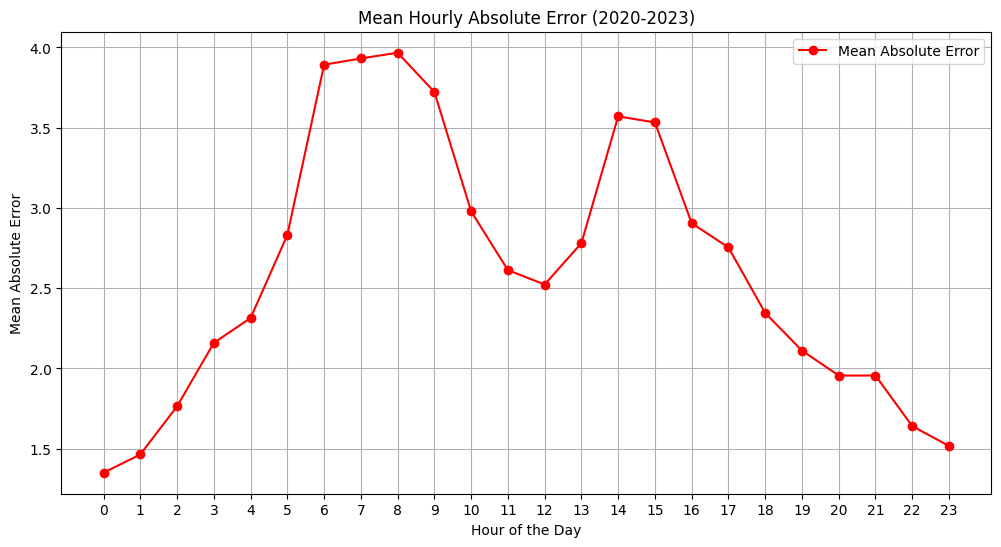

Hour
0     1.350600
1     1.464440
2     1.764203
3     2.159442
4     2.314305
5     2.831499
6     3.892171
7     3.931202
8     3.966879
9     3.722236
10    2.978723
11    2.612552
12    2.523057
13    2.780942
14    3.570783
15    3.532262
16    2.905001
17    2.753775
18    2.345629
19    2.111326
20    1.955901
21    1.956010
22    1.640652
23    1.517393
Name: absolute_error, dtype: float64


In [19]:
# mean hourly absolute errors

errors['Hour'] = errors.index.hour

# mean
mean_absolute_errors_by_hour = errors.groupby('Hour')['absolute_error'].mean()

# plot
plt.figure(figsize=(12, 6))
plt.plot(mean_absolute_errors_by_hour.index, mean_absolute_errors_by_hour, label='Mean Absolute Error', marker='o', color='red')

plt.xlabel('Hour of the Day')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Hourly Absolute Error (2020-2023)')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(range(24))
plt.show()

print(mean_absolute_errors_by_hour)

In [20]:
# actual measurements for 1 day (24 steps) into the future
r_humidity_hourly = humidity_hourly['RELATIVE_HUMIDITY']
actual_values_humidity_23 = r_humidity_hourly['2023'].head(24)
print(actual_values_humidity_23)

2023-01-01 00:00:00+00:00    88.550000
2023-01-01 01:00:00+00:00    89.966667
2023-01-01 02:00:00+00:00    90.025000
2023-01-01 03:00:00+00:00    89.883333
2023-01-01 04:00:00+00:00    90.566667
2023-01-01 05:00:00+00:00    90.400000
2023-01-01 06:00:00+00:00    88.933333
2023-01-01 07:00:00+00:00    89.658333
2023-01-01 08:00:00+00:00    86.708333
2023-01-01 09:00:00+00:00    77.425000
2023-01-01 10:00:00+00:00    57.750000
2023-01-01 11:00:00+00:00    54.600000
2023-01-01 12:00:00+00:00    56.966667
2023-01-01 13:00:00+00:00    58.808333
2023-01-01 14:00:00+00:00    69.325000
2023-01-01 15:00:00+00:00    76.016667
2023-01-01 16:00:00+00:00    79.950000
2023-01-01 17:00:00+00:00    84.941667
2023-01-01 18:00:00+00:00    88.325000
2023-01-01 19:00:00+00:00    90.575000
2023-01-01 20:00:00+00:00    91.325000
2023-01-01 21:00:00+00:00    91.575000
2023-01-01 22:00:00+00:00    91.983333
2023-01-01 23:00:00+00:00    91.883333
Freq: H, Name: RELATIVE_HUMIDITY, dtype: float64


                              Actual  ARIMA(3,0,4)  \
2023-01-01 00:00:00+00:00  88.550000     87.858618   
2023-01-01 01:00:00+00:00  89.966667     87.236773   
2023-01-01 02:00:00+00:00  90.025000     86.159345   
2023-01-01 03:00:00+00:00  89.883333     84.580569   
2023-01-01 04:00:00+00:00  90.566667     82.587084   
2023-01-01 05:00:00+00:00  90.400000     80.295050   
2023-01-01 06:00:00+00:00  88.933333     77.842060   
2023-01-01 07:00:00+00:00  89.658333     75.377634   
2023-01-01 08:00:00+00:00  86.708333     73.052927   
2023-01-01 09:00:00+00:00  77.425000     71.010381   
2023-01-01 10:00:00+00:00  57.750000     69.373986   
2023-01-01 11:00:00+00:00  54.600000     68.240842   
2023-01-01 12:00:00+00:00  56.966667     67.674566   
2023-01-01 13:00:00+00:00  58.808333     67.701005   
2023-01-01 14:00:00+00:00  69.325000     68.306520   
2023-01-01 15:00:00+00:00  76.016667     69.438964   
2023-01-01 16:00:00+00:00  79.950000     71.011279   
2023-01-01 17:00:00+00:00  8

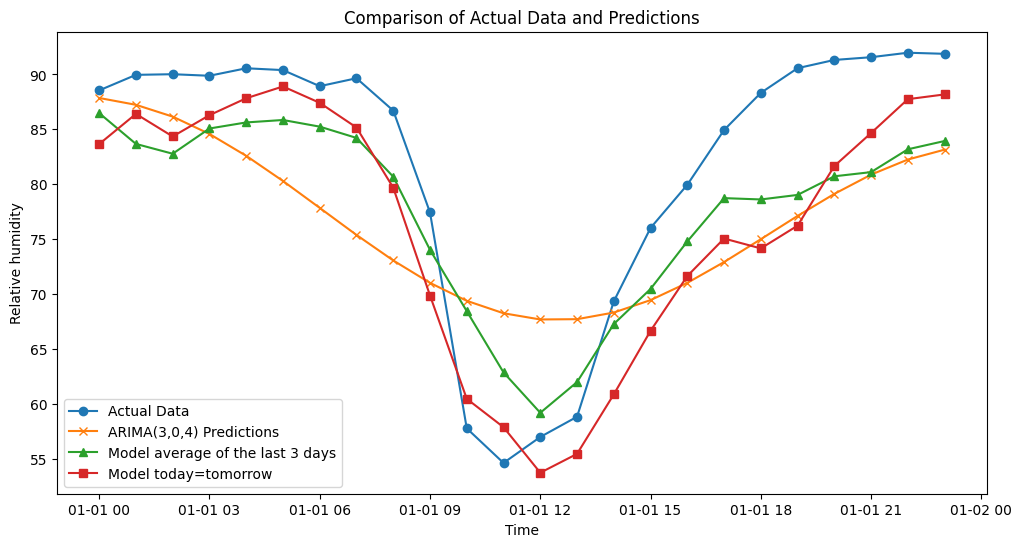

In [21]:
# comparing the models with the actual data
# change p,d,q to the best found

comparison_humidity = pd.DataFrame({
    'Actual': actual_values_humidity_23,
    'ARIMA(3,0,4)': forecast_values_304,
    'Model average of the last 3 days': last_3_humidity,
    'Model today=tomorrow': today_is_tomorrow_humidity
})

print(comparison_humidity)

plt.figure(figsize=(12,6))

plt.plot(comparison_humidity.index, comparison_humidity['Actual'], label='Actual Data', marker='o')
plt.plot(comparison_humidity.index, comparison_humidity['ARIMA(3,0,4)'], label='ARIMA(3,0,4) Predictions', marker='x')
plt.plot(comparison_humidity.index, comparison_humidity['Model average of the last 3 days'], label='Model average of the last 3 days', marker='^')
plt.plot(comparison_humidity.index, comparison_humidity['Model today=tomorrow'], label='Model today=tomorrow', marker='s')

plt.xlabel('Time')
plt.ylabel('Relative humidity')
plt.title('Comparison of Actual Data and Predictions')
plt.legend()
plt.show()

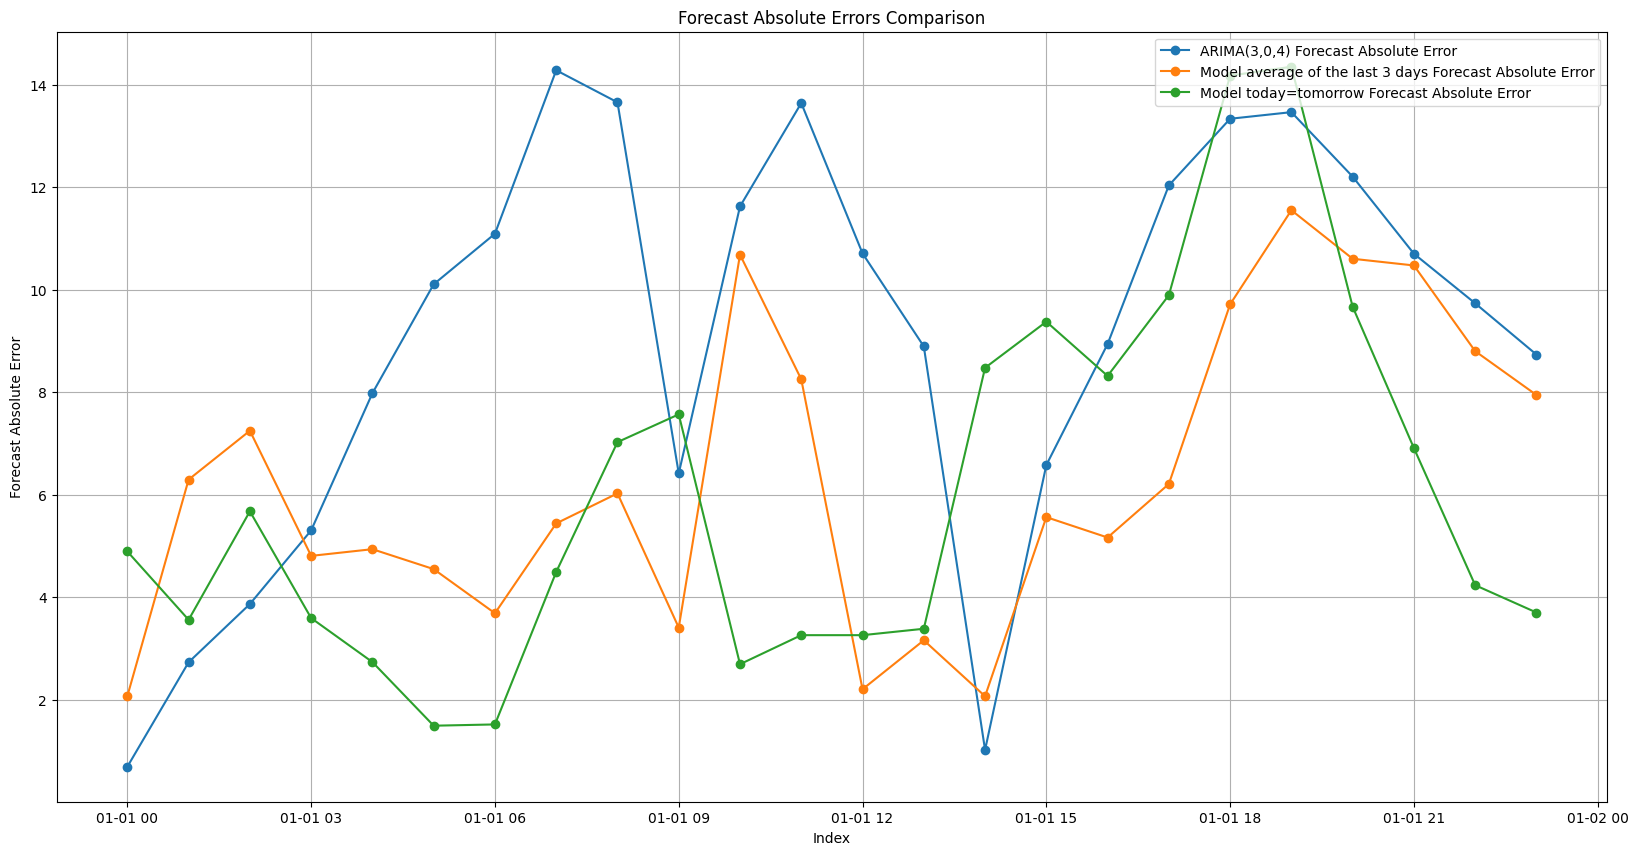

ARIMA(3,0,4) Forecast Absolute Error                        9.071740
Model average of the last 3 days Forecast Absolute Error    6.284722
Model today=tomorrow Forecast Absolute Error                6.009375
dtype: float64


In [22]:
# 4 models' predictions compared to the actual data

# absolute errors of all the modela
forecast_absolute_errors = pd.DataFrame()
for column in comparison_humidity.columns:
    if column != 'Actual':
        forecast_absolute_errors[column + ' Forecast Absolute Error'] = (comparison_humidity['Actual'] - comparison_humidity[column]).abs()

# plot
plt.figure(figsize=(20, 10))
for column in forecast_absolute_errors.columns:
    plt.plot(forecast_absolute_errors[column], label=column, marker='o')

plt.xlabel('Index')
plt.ylabel('Forecast Absolute Error')
plt.title('Forecast Absolute Errors Comparison')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# values 
#print(forecast_absolute_errors)

# mean errors
print(forecast_absolute_errors.mean())
